[ 경사하강법을 검증합니다. ]
W1 : 0.0001695026
b1 : 0.0011716272
W2 : -0.0000000000
b2 : -0.0000000000

============= 학습 시작 =============
epochs: 0; loss: 2.228223; accuracy: 0.431350
epochs: 1; loss: 1.342075; accuracy: 0.702650
epochs: 2; loss: 0.713305; accuracy: 0.821283
epochs: 3; loss: 0.531513; accuracy: 0.861500
epochs: 4; loss: 0.451468; accuracy: 0.879250
epochs: 5; loss: 0.407398; accuracy: 0.889083
epochs: 6; loss: 0.379289; accuracy: 0.894800
epochs: 7; loss: 0.359285; accuracy: 0.899600
epochs: 8; loss: 0.344327; accuracy: 0.903133
epochs: 9; loss: 0.332020; accuracy: 0.905833
epochs: 10; loss: 0.321884; accuracy: 0.908983
epochs: 11; loss: 0.313065; accuracy: 0.911367
epochs: 12; loss: 0.305127; accuracy: 0.913667
epochs: 13; loss: 0.298049; accuracy: 0.915600
epochs: 14; loss: 0.291386; accuracy: 0.917567
epochs: 15; loss: 0.285155; accuracy: 0.919667
epochs: 16; loss: 0.279398; accuracy: 0.921533
epochs: 17; loss: 0.273919; accuracy: 0.922483
epochs: 18; loss: 0.268649; accuracy:

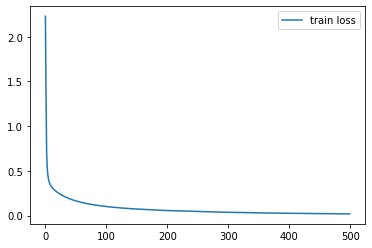

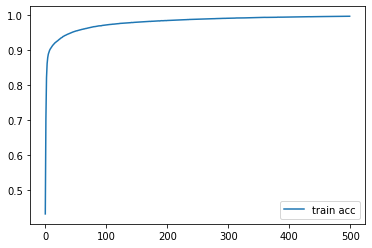

In [22]:
from collections import OrderedDict
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


def softmax(a):
  if a.ndim == 2:
    a = a.T
    c = np.max(a, axis = 0)
    exp_a = np.exp(a - c) # 오버 플로우를 방지하기 위해 c를 빼준다.
    exp_a = exp_a / np.sum(exp_a, axis=0)
    return exp_a.T

  c = np.max(a)
  exp_a = np.exp(a - c)
  return exp_a / np.sum(exp_a)

def cross_entropy_error(x, t):
  return -np.sum(t * np.log(x)) / x.shape[0]

# 수치 미분 함수
def numerical_gradient(func, param):
  h = 1e-4
  grad = np.zeros_like(param)
  expand = False

  if param.ndim == 1:
    param = np.expand_dims(param, axis=0)
    grad = np.expand_dims(grad, axis=0)
    expand = True

  for x in range(param.shape[0]):
    for y in range(param.shape[1]):
      tmp_val = param[x, y]
      param[x, y] = tmp_val + h
      fxh1 = func(param)

      param[x, y] = tmp_val - h
      fxh2 = func(param)

      grad[x, y] = (fxh1 - fxh2) / 2*h
      param[x, y] = tmp_val

  if expand:
    param = param.reshape(-1)
    grad = grad.reshape(-1)
  
  return grad

# affine transformation
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    self.dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0) 
     
    return self.dx

# 렐루 층
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dout

# 소프트맥스 함수와, 손실함수가 합쳐진 층
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    return (self.y - self.t) / batch_size


class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01, lr=0.01, batch_size=100, epochs=500):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()

    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis = 1)
    accuracy = np.sum(y == np.argmax(t, axis=1))
    return accuracy / float(y.shape[0])

  # 수치미분
  def numerical_gradient(self, x, t):
    loss_W = lambda W : self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

  # SGD를 통해 가중치 수정값 계산하기
  def gradient(self, x, t):
    self.loss(x, t) # 순전파 구현하기

    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db
    
    return grads

  # 수치미분과, 해석적미분 값을 비교해서 SGD를 검증한다.
  def verify_grad(self, x, t):
    print("[ 경사하강법을 검증합니다. ]")
    x_val = x[:3]
    t_val = t[:3]

    grad = self.gradient(x_val, t_val)
    grad_num = self.numerical_gradient(x_val, t_val)

    for key in grad.keys():
      print(str(key) + " : %.10lf" % np.mean(grad[key] - grad_num[key]))
  
  # 배치 생성 함수
  def generate_batch(self, x, t):
    random_mask = np.random.permutation(range(x.shape[0]))
    x = x[random_mask]
    t = t[random_mask]

    batch_iters = int(x.shape[0] / self.batch_size)

    for i in range(batch_iters):
      start = i * self.batch_size
      end = (i+1) * self.batch_size
      yield x[start:end], t[start:end]
  
  # 학습 함수
  def fit(self, x, t):
    print()
    print("============= 학습 시작 =============")
    history = {}
    history['loss'] = []
    history['acc'] = []

    for i in range(self.epochs):
      train_batch_loss = []
      train_batch_acc = []
      for x_batch, t_batch in self.generate_batch(x, t):
        grad = network.gradient(x_batch, t_batch)

        for key in ('W1', 'b1', 'W2', 'b2'):
          self.params[key] -= self.lr * grad[key]
        
        train_batch_loss.append(self.loss(x_batch, t_batch))
        train_batch_acc.append(self.accuracy(x_batch, t_batch))
      loss_mean = np.mean(train_batch_loss)
      acc_mean = np.mean(train_batch_acc)

      history['loss'].append(loss_mean)
      history['acc'].append(acc_mean)
      print("epochs: %d; loss: %f; accuracy: %f" % (i, loss_mean, acc_mean))
    return history

(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train / 255.0).astype(np.float32)
x_train = x_train.reshape(-1, 784)

t_train = to_categorical(t_train)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) # 모델 구축
network.verify_grad(x_train, t_train) # SGD 코드를 검사한다.
history = network.fit(x_train, t_train) # 학습 시행

# 결과값 그리기
plt.plot(range(network.epochs), history['loss'], label="train loss")
plt.legend()
plt.show()

plt.plot(range(network.epochs), history['acc'], label="train acc")
plt.legend()
plt.show()
